# IMPORT LIBRARY

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import random
from torch.utils.data import DataLoader, TensorDataset, Subset

In [2]:
import torch

# Kiểm tra xem GPU có sẵn không
print("GPU is available:", torch.cuda.is_available())

# Nếu có GPU, in ra tên GPU
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU Index:", torch.cuda.current_device())


GPU is available: True
GPU Name: Tesla P100-PCIE-16GB
CUDA Version: 12.1
Number of GPUs: 1
Current GPU Index: 0


# READ IMAGE

In [3]:
def read_image(img_path):
    img = cv2.imread(img_path)  # Đọc ảnh
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
    img = cv2.resize(img, (224, 224))  # Resize ảnh về 224x224
    return img 

In [4]:
DATASET_DIR = "/kaggle/input/cs331-lab1/Dataset"
FOLDER = ["men", "women"]

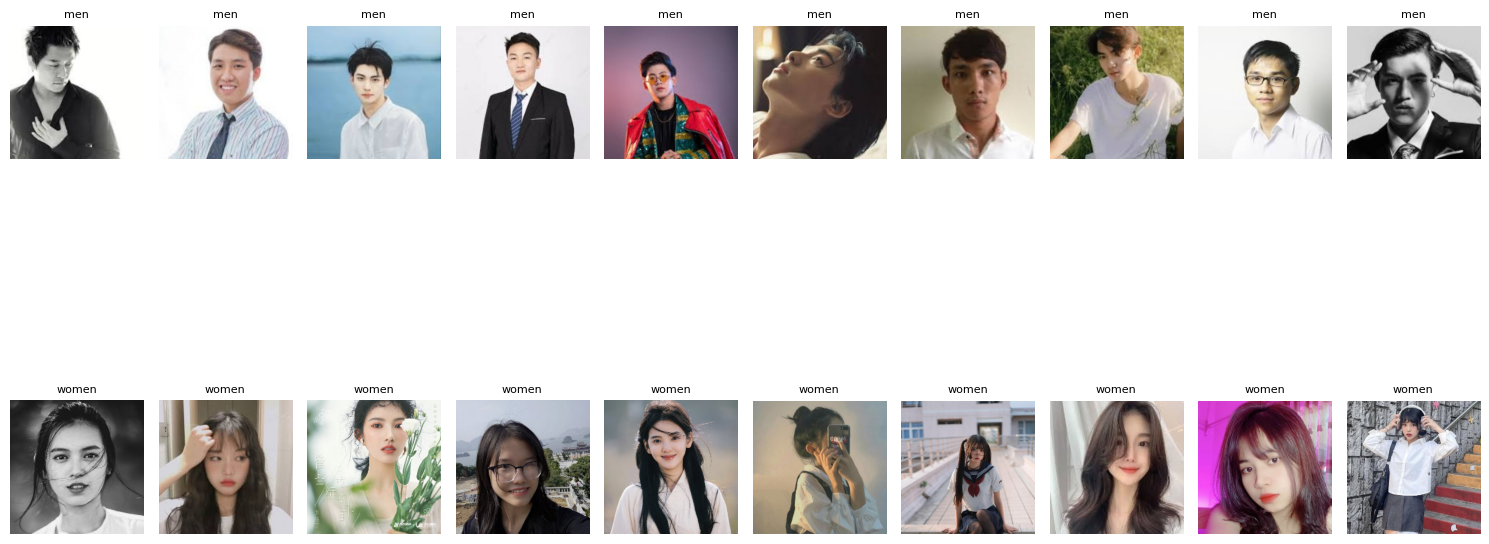

In [5]:
display_image = []
display_label = []

for label in FOLDER:
    folder_path = os.path.join(DATASET_DIR, label)
    full_image_file = os.listdir(folder_path)

    # Lấy tối đa 10 ảnh (nếu có ít hơn thì lấy tất cả)
    num_images = min(10, len(full_image_file))

    for i in range(num_images):
        image_name = full_image_file[i]
        image_path = os.path.join(folder_path, image_name)
        img = read_image(image_path)  # Hàm đọc ảnh (định nghĩa sẵn)
        display_image.append(img)
        display_label.append(label)  # Lưu nhãn tương ứng

# Hiển thị ảnh
plt.figure(figsize=(15, 10))

for i, img in enumerate(display_image):
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.axis("off")  # Ẩn trục tọa độ
    plt.title(display_label[i], fontsize=8)  # Hiển thị tiêu đề

plt.tight_layout()
plt.show()

In [6]:
del display_image, display_label

In [7]:
data_files = []
labels = []
for label in FOLDER:
    folder_path = os.path.join(DATASET_DIR, label)
    for file in os.listdir(folder_path):
        labels.append(label)
        image_path = os.path.join(folder_path, file) 
        data_files.append(image_path)

print(len(data_files))
print(len(labels))
    

400
400


In [8]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
print(len(labels))

400


In [9]:
# Chia dữ liệu thành train (80%) và test+val (20%)
train_data_files, test_data_files, train_labels, test_labels = train_test_split(
    data_files, labels, test_size=0.2, random_state=42
)
val_data_files, test_data_files, val_labels, test_labels = train_test_split(
    test_data_files, test_labels, test_size=0.5, random_state=42
)
print(f"Train data files {len(train_data_files)}")
print(f"Train labels {len(train_labels)}")
print(f"Val data files {len(val_data_files)}")
print(f"Val labels {len(val_labels)}")
print(f"Test data files {len(test_data_files)}")
print(f"Test labels {len(test_labels)}")

Train data files 320
Train labels 320
Val data files 40
Val labels 40
Test data files 40
Test labels 40


# AUGMENTATION

In [10]:
def augment_image(img, img_size=(224, 224), num_augments=5):
    augmented_images = []
    img_resized = cv2.resize(img, img_size)

    for _ in range(num_augments):
        # Biến đổi ngẫu nhiên
        angle = random.randint(-45, 45)  # Xoay từ -15 đến 15 độ
        scale = random.uniform(0.7, 1.2)  # Phóng to/thu nhỏ ngẫu nhiên
        brightness = random.uniform(0.7, 1.3)  # Thay đổi độ sáng
        flip = random.choice([True, False])  # Lật ngẫu nhiên

        # Xoay và phóng to/thu nhỏ
        center = (img_size[0] // 2, img_size[1] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        img_aug = cv2.warpAffine(img_resized, rotation_matrix, img_size)

        # Thay đổi độ sáng
        img_aug = np.clip(img_aug * brightness, 0, 255).astype(np.uint8)

        # Lật ảnh nếu flip = True
        if flip:
            img_aug = cv2.flip(img_aug, 1)  # Lật ngang

        augmented_images.append(img_aug)

    return augmented_images

In [11]:
def show_images(images, titles=None, cols=6, figsize=(15, 10)):
    rows = (len(images) + cols - 1) // cols  # Tính số hàng cần thiết
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)  # Vẽ ảnh lên lưới
        plt.imshow(img)  
        plt.axis("off")  # Ẩn trục tọa độ
        if titles:
            plt.title(titles[i], fontsize=8)  # Hiển thị tiêu đề (nếu có)

    plt.tight_layout()  
    plt.show()

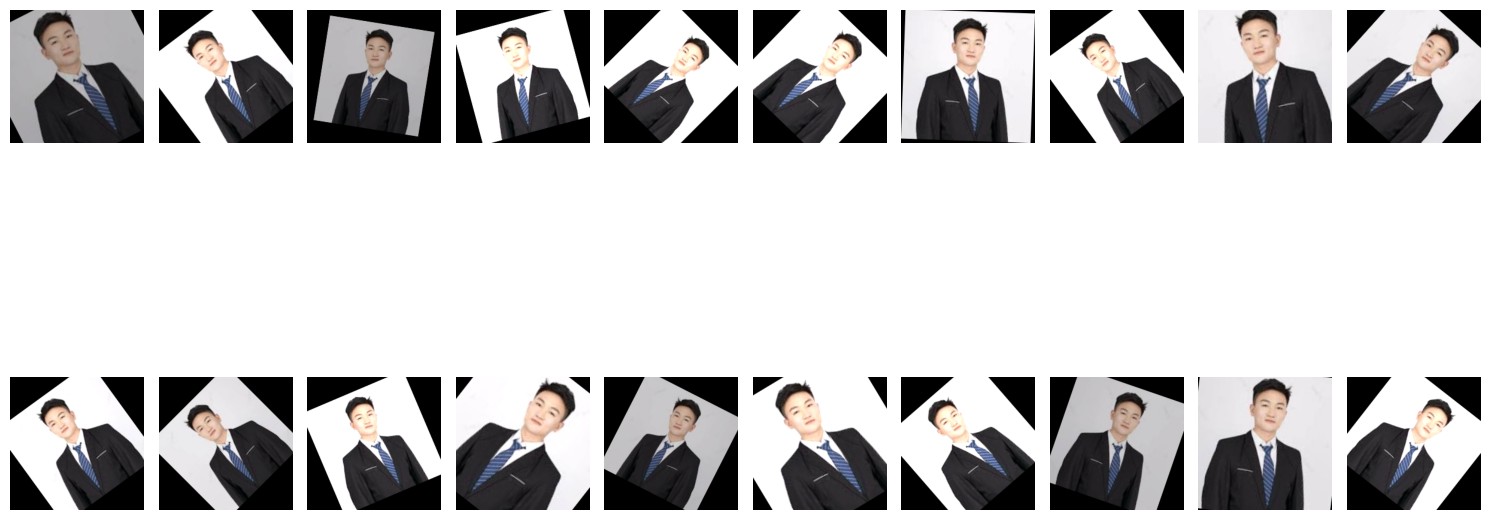

In [12]:
show_img = read_image(train_data_files[0])
augmented_images = augment_image(show_img, num_augments=20)

show_images(augmented_images, cols= 10)
del show_img, augmented_images


# NORMALIZE 

In [13]:
X_val = []
X_test = []

# Đọc ảnh cho tập validation
for file_image in val_data_files:   
    img = read_image(file_image)  
    img = img.astype('float32') / 255.0  
    X_val.append(img)

# Đọc ảnh cho tập test
for file_image in test_data_files:
    img = read_image(file_image)
    img = img.astype('float32') / 255.0
    X_test.append(img)


In [16]:
# del X_val, X_test 

In [14]:
X_train = []
y_train = []
num_augmentations = 20

for file_image in train_data_files:  # Không dùng enumerate
    index = train_data_files.index(file_image)  # Lấy chỉ số thực sự
    sample_label = train_labels[index]  # Lấy nhãn tương ứng
    
    img = read_image(file_image)  # Đọc ảnh từ đường dẫn
    augmented_images = augment_image(img, num_augments=num_augmentations)
    
    img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh gốc
    X_train.append(img)
    y_train.append(sample_label)
    
    for arg_img in augmented_images:
        arg_img_normalize = arg_img.astype('float32') / 255.0
        X_train.append(arg_img_normalize)  # Đúng, thêm ảnh augment
        y_train.append(sample_label)  # Nhãn giữ nguyên

# for img in X_train_new:
#     if img.shape != (224,224,3):
#         print(img.shape)
# Chuyển về numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)
# del X_train_new, y_train_new

print(f"Số lượng ảnh sau augmentation: {X_train.shape}")
print(f"Số lượng nhãn sau augmentation: {y_train.shape}")


Số lượng ảnh sau augmentation: (6720, 224, 224, 3)
Số lượng nhãn sau augmentation: (6720,)


In [15]:
def transform_data(data, label, batch_size=32):
    """
    Chuyển dữ liệu từ NumPy array sang PyTorch tensor và tạo DataLoader cho CIFAR-10.

    Args:
        data (numpy.ndarray): Dữ liệu đầu vào (hình ảnh).
        label (numpy.ndarray): Nhãn tương ứng.
        batch_size (int): Kích thước batch khi huấn luyện.

    Returns:
        DataLoader: DataLoader để huấn luyện hoặc kiểm tra.
    """
    # Chuyển `data` từ NumPy array sang PyTorch tensor kiểu float32 và định dạng (N, C, H, W)
    data = torch.from_numpy(data).float().permute(0, 3, 1, 2)  # Chuyển (N, H, W, C) -> (N, C, H, W)

    # Chuyển `label` từ NumPy array sang tensor kiểu long
    label = torch.from_numpy(label).long().squeeze()  # Xóa trục dư thừa nếu nhãn ở dạng (N, 1)

    # Tạo TensorDataset và DataLoader
    _data = TensorDataset(data, label)
    data_loader = DataLoader(_data, batch_size=batch_size, shuffle=True)

    return data_loader, _data

In [16]:
X_test = np.array(X_test)
y_test = np.array(test_labels)
X_val = np.array(X_val)
y_val = np.array(val_labels)
train_loader, train_tensor = transform_data(X_train, y_train, batch_size = 16)
test_loader, _ = transform_data(X_test, y_test, batch_size = 1)
val_loader, _ = transform_data(X_val, y_val, batch_size = 1)

In [20]:
# del X_val_new, X_test_new

In [17]:
# Hàm để in kích thước của data và label trong DataLoader
def print_loader_shapes(data_loader, loader_name):
    print(f"\n{loader_name}:")

    for batch_idx, (data, labels) in enumerate(data_loader):
        print(f"  Batch {batch_idx + 1}:")
        print(f"    Data shape: {data.shape}")   # Kích thước của dữ liệu
        print(f"    Labels shape: {labels.shape}")  # Kích thước của nhãn
        break  # Dừng sau batch đầu tiên (nếu chỉ cần kiểm tra một batch)

# In kích thước của từng DataLoader
print_loader_shapes(train_loader, "Train Loader")
print_loader_shapes(test_loader, "Test Loader")
print_loader_shapes(val_loader, "Validation Loader")


Train Loader:
  Batch 1:
    Data shape: torch.Size([16, 3, 224, 224])
    Labels shape: torch.Size([16])

Test Loader:
  Batch 1:
    Data shape: torch.Size([1, 3, 224, 224])
    Labels shape: torch.Size([1])

Validation Loader:
  Batch 1:
    Data shape: torch.Size([1, 3, 224, 224])
    Labels shape: torch.Size([1])


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AlexnetV2(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexnetV2, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # 1st Conv Layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 2nd Conv Layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 3rd Conv Layer
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 4th Conv Layer
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 5th Conv Layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),  # Fully Connected Layer 1
            nn.ReLU(),
            
            nn.Linear(512, 512),  # Fully Connected Layer 2
            nn.ReLU(),
            
            nn.Linear(512, num_classes)  # Output Layer
        )

    
    def forward(self, x):
        return self.model(x)
    
    def fit(self, num_epochs, train_loader, val_loader, base_lr=0.001, scheduler=None, verbose=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.train()
        
        optimizer = optim.Adam(self.parameters(), lr=base_lr, weight_decay=0.0001)
        
        history = {'epoch_loss': [], 'epoch_accuracy': [], 'val_accuracy': []}
        
        for epoch in range(num_epochs):
            running_loss, correct_train, total_train = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)
            
            epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
            epoch_accuracy = correct_train / total_train if total_train > 0 else 0
            history['epoch_loss'].append(epoch_loss)
            history['epoch_accuracy'].append(epoch_accuracy)
            
            val_accuracy = self._evaluate(val_loader, device)
            history['val_accuracy'].append(val_accuracy)
            
            if scheduler:
                scheduler.step()
            
            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}, Train Acc: {epoch_accuracy:.6f}, Val Acc: {val_accuracy:.6f}")
        return history
    
    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()
        predictions = []
        
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        
        return np.array(predictions)
    
    def evaluate(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()
        accuracy = self._evaluate(test_loader, device)
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy
    
    def _evaluate(self, data_loader, device):
        self.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return correct / total if total > 0 else 0


In [19]:
model = AlexnetV2()
print(model)

AlexnetV2(
  (criterion): CrossEntropyLoss()
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): ReLU()
    (18): 

In [20]:
def train_model_kfold(model, dataset,test_loader, num_epochs= 15, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        model_train = model = AlexnetV2()
        print(f"\n📌 Fold {fold+1}/{k}")

        # Chia dữ liệu thành train và val
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=16, shuffle=True)
        
        model_train.fit(train_loader= train_loader, val_loader= val_loader,num_epochs= num_epochs, base_lr=0.0001, verbose= True)
        model_train.evaluate(test_loader)
        del model_train

model = AlexnetV2()
train_model_kfold(model, dataset= train_tensor, test_loader= test_loader, num_epochs = 15, k = 5)


📌 Fold 1/5
Epoch 1/15, Loss: 0.604219, Train Acc: 0.665551, Val Acc: 0.764881
Epoch 2/15, Loss: 0.442770, Train Acc: 0.789807, Val Acc: 0.829613
Epoch 3/15, Loss: 0.324881, Train Acc: 0.848028, Val Acc: 0.871280
Epoch 4/15, Loss: 0.265052, Train Acc: 0.880022, Val Acc: 0.901042
Epoch 5/15, Loss: 0.200998, Train Acc: 0.915179, Val Acc: 0.889137
Epoch 6/15, Loss: 0.163059, Train Acc: 0.930990, Val Acc: 0.929315
Epoch 7/15, Loss: 0.113135, Train Acc: 0.958147, Val Acc: 0.945685
Epoch 8/15, Loss: 0.076053, Train Acc: 0.973400, Val Acc: 0.968750
Epoch 9/15, Loss: 0.076723, Train Acc: 0.970982, Val Acc: 0.970238
Epoch 10/15, Loss: 0.061424, Train Acc: 0.978051, Val Acc: 0.965774
Epoch 11/15, Loss: 0.032859, Train Acc: 0.986235, Val Acc: 0.984375
Epoch 12/15, Loss: 0.037766, Train Acc: 0.985677, Val Acc: 0.970982
Epoch 13/15, Loss: 0.036695, Train Acc: 0.988467, Val Acc: 0.982887
Epoch 14/15, Loss: 0.028294, Train Acc: 0.989211, Val Acc: 0.950149
Epoch 15/15, Loss: 0.031892, Train Acc: 0.988

In [21]:
num_epochs = 30
result = {}
num_classes = 2
history = model.fit(num_epochs=num_epochs, train_loader=train_loader, val_loader=val_loader, base_lr= 0.0001, verbose=True)

Epoch 1/30, Loss: 0.640756, Train Acc: 0.602530, Val Acc: 0.775000
Epoch 2/30, Loss: 0.404464, Train Acc: 0.814286, Val Acc: 0.775000
Epoch 3/30, Loss: 0.298209, Train Acc: 0.868006, Val Acc: 0.900000
Epoch 4/30, Loss: 0.208121, Train Acc: 0.914583, Val Acc: 0.875000
Epoch 5/30, Loss: 0.159284, Train Acc: 0.935863, Val Acc: 0.850000
Epoch 6/30, Loss: 0.109000, Train Acc: 0.956845, Val Acc: 0.925000
Epoch 7/30, Loss: 0.074625, Train Acc: 0.973363, Val Acc: 0.925000
Epoch 8/30, Loss: 0.050141, Train Acc: 0.981696, Val Acc: 0.850000
Epoch 9/30, Loss: 0.048978, Train Acc: 0.982292, Val Acc: 0.825000
Epoch 10/30, Loss: 0.049538, Train Acc: 0.981399, Val Acc: 0.925000
Epoch 11/30, Loss: 0.014131, Train Acc: 0.995982, Val Acc: 0.925000
Epoch 12/30, Loss: 0.040604, Train Acc: 0.986161, Val Acc: 0.900000
Epoch 13/30, Loss: 0.026277, Train Acc: 0.991518, Val Acc: 0.925000
Epoch 14/30, Loss: 0.019536, Train Acc: 0.993750, Val Acc: 0.950000
Epoch 15/30, Loss: 0.014655, Train Acc: 0.994643, Val Acc

In [23]:
model.evaluate(test_loader)

Test Accuracy: 0.85%


0.85